In [1]:
from pathlib import Path
DATA = Path('/data2/nelson_projs/ucsi')

In [2]:
THRESHOLD = 0.5

In [3]:
import os
import cv2
import pdb
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler

from matplotlib import pyplot as plt

from albumentations import (HorizontalFlip, RGBShift, ElasticTransform, GridDistortion,RandomBrightness ,ShiftScaleRotate, Normalize, Resize, Compose, OpticalDistortion,GaussNoise,Lambda)
from albumentations.pytorch import ToTensor

from sklearn import model_selection
#from fastai.vision import *

from ranger import Ranger
import segmentation_models_pytorch as smp

In [16]:
def rle_decode(mask_rle: str = ''):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    shape = (1400, 2100)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')


def make_mask(df: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (1400, 2100)):
    """
    Create mask based on df, image name and shape.
    """
    encoded_masks = df.loc[df['im_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask
            
    return masks

def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')

def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [5]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        Lambda(image=preprocessing_fn),
        Lambda(image=to_tensor, mask=to_tensor),
    ]
    return Compose(_transform)

In [6]:
train = pd.read_csv(f'{DATA}/train.csv')
sub = pd.read_csv(f'{DATA}/sample_submission.csv')

In [7]:
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
train['im_id'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

#sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
#sub['im_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

In [8]:
def get_training_augmentation():
    train_transform = [

        HorizontalFlip(p=0.5),
        ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        GridDistortion(p=0.5),
        OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5),
        Resize(320, 640)
    ]
    return Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        Resize(320, 640)
    ]
    return Compose(test_transform)


In [9]:
class CloudDataset(Dataset):
    def __init__(self, df: pd.DataFrame = None, datatype: str = 'train', img_ids: np.array = None,
                 transforms = Compose([HorizontalFlip(),ToTensor()]),
                preprocessing=None):
        self.df = df
        if datatype != 'test':
            self.data_folder = f"{DATA}/train_images"
        else:
            self.data_folder = f"{DATA}/test_images"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

In [10]:
id_mask_count = train.loc[train['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().\
reset_index().rename(columns={'index': 'img_id', 'Image_Label': 'count'})
train_ids, valid_ids = train_test_split(id_mask_count['img_id'].values, random_state=42, stratify=id_mask_count['count'], test_size=0.1)
#test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [11]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [12]:
num_workers = 0
bs = 16

train_dataset = CloudDataset(df=train, datatype='train', img_ids=train_ids, transforms = get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))
valid_dataset = CloudDataset(df=train, datatype='valid', img_ids=valid_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn))

#train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
#valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

#loaders = {
#    "train": train_loader,
#    "valid": valid_loader
#}

/home/nelson/.local/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2874: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [13]:
from fastai.vision import *
data = DataBunch.create(train_dataset, valid_dataset, bs=16, num_workers=8)


In [17]:
x,y = data.one_batch()

In [18]:
x.size(),y.size()

(torch.Size([16, 3, 320, 640]), torch.Size([16, 4, 320, 640]))

In [19]:
def metricSeg(probability, truth, threshold=THRESHOLD, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    probability = torch.sigmoid(probability)
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > threshold).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class dices(LearnerCallback):
    _order = -20 # Needs to run before the recorder, very CRITICAL step
    def __init__(self,learn):
        super().__init__(learn)
        
    def on_train_begin(self,**kwargs):
        self.learn.recorder.add_metric_names(['dice','dice_neg','dice_pos','num_neg','num_pos'])
        
    def on_epoch_begin(self,**kwargs):
        self.ttl_dice = []
        self.ttl_dice_neg = []
        self.ttl_dice_pos = []
        self.ttl_num_neg = []
        self.ttl_num_pos = []
        self.ttl_lists = [self.ttl_dice,self.ttl_dice_neg,self.ttl_dice_pos,self.ttl_num_neg,self.ttl_num_pos]
    
    def on_batch_end(self,last_output,last_target,**kwargs):
        dice, dice_neg, dice_pos, num_neg, num_pos = metricSeg(last_output,last_target)
        self.ttl_dice.append(dice)
        self.ttl_dice_neg.append(dice_neg)
        self.ttl_dice_pos.append(dice_pos)
        self.ttl_num_neg.append(num_neg)
        self.ttl_num_pos.append(num_pos)
    
    def on_epoch_end(self,last_metrics,**kwargs):
        extras = [sum(i)/float(len(i)) for i in self.ttl_lists]
#         print(extras)
        return add_metrics(last_metrics, extras)
    
class cutHorizonCallback(Callback):
    def __init__(self):
        super().__init__()
        
    def on_batch_begin(self, last_input, last_target,**kwargs):
        last_input = to416(cutHorizontal(last_input))
        last_target = to416(cutHorizontal(last_target))


In [20]:
optar = partial(Ranger)
learn = Learner(data, model, metrics = [], opt_func=optar, loss_func = nn.BCEWithLogitsLoss(),callback_fns = dices).to_fp16()
learn.path = Path("./fastai")

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


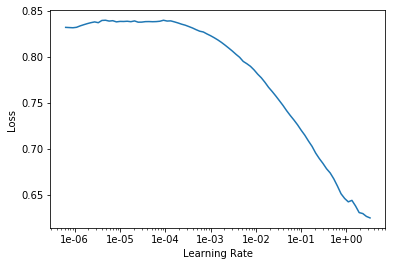

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
from fastai.callbacks import SaveModelCallback

In [ ]:
lr = 1e-3
learn.fit_one_cycle(2,lr, callbacks=[
#                                         dices(learn),
#                                       cutHorizonCallback(),
                                       SaveModelCallback(learn, every='epoch', monitor='loss')])